# Exercise 3
Scale-free networks and networks attacks

In [124]:
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import math as math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Scale-free networks.

Generate a scale-free network with $10000$ edges and add $10$ nodes in each
step (use the method *barabasi_albert_ graph(n, m)*). 

Calculate the values of $L$, $C$ and the degree distribution of the nodes. 

Generate a random network that has the same number of nodes and branches as the network that you have created.

Calculate your values of $L$, $C$ and the degree distribution of the nodes and compare the values
obtained.

### L & C

In [128]:
def get_graph_metrics(graph):
    largest_cc = max(nx.connected_components(graph), key=len)   
    largest_connected_subgraph = graph.subgraph(largest_cc)
    if not nx.is_connected(graph): 
        subgraph = largest_connected_subgraph
    else:
        subgraph = graph
    return nx.average_clustering(graph),\
           nx.average_shortest_path_length(subgraph),\
           largest_connected_subgraph.order()
    
def l_c_random(n_graph, n, p):
    acum_c = 0
    acum_l = 0
    acum_o = 0
    for i in range(0, n_graph):
        graph = nx.gnp_random_graph(n, p)
        c, l, o = get_graph_metrics(graph)
        acum_c += c
        acum_l += l
        acum_o += o
    return [acum_c/n_graph, acum_l/n_graph, acum_o/n_graph]

def graph_metric(metric, graph):
    """
    Promediate a node metric to all the nodes of the graph
    """
    method = getattr(nx, metric)
    return sum(method(graph).values())/graph.order()

def max_kcore_k(graph):
    core_number = nx.core_number(graph)
    max_kcore = 0
    for node in core_number:
        if core_number[node] > max_kcore:
            max_kcore = core_number[node]
    return max_kcore  

def get_graph_metrics(graph):
    largest_cc = max(nx.connected_components(graph), key=len)   
    largest_connected_subgraph = graph.subgraph(largest_cc)
    return [graph_metric("degree_centrality", graph),
           graph_metric("closeness_centrality", graph),
           graph_metric("betweenness_centrality", graph), 
           nx.graph_clique_number(graph),
           nx.average_clustering(graph),
           max_kcore_k(graph),
           nx.average_shortest_path_length(largest_connected_subgraph)]

In [3]:
order = 10000
edges = 10
graph_free_scale_barabasi = nx.barabasi_albert_graph(order, edges)
c, l, o = get_graph_metrics(graph_free_scale_barabasi)

In [6]:
print(c, l, o)
# Result : 0.011121720734477772 3.0628272427242726 10000

0.011121720734477772 3.0628272427242726 10000


In [4]:
print("Free scale graph size:", graph_free_scale_barabasi.size())
graph_random = nx.gnm_random_graph(order, graph_free_scale_barabasi.size())
c_random, l_random, o_random = get_graph_metrics(graph_random)

d = {'Free Scale': [c, l], 'Random': [c_random, l_random]}
df = pd.DataFrame(data=d, index = ['Average clustering',
                                   'Average shortest path length'])
df

Free scale graph size: 99900


,Free Scale,Random
Average clustering,0.011050,0.001928
Average shortest path length,3.062604,3.403116


### Node degree distribution

Plot by curves.

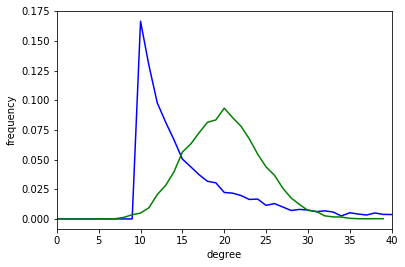

In [14]:
plt.xlabel('degree')
plt.ylabel('frequency')
plt.xlim(0, 40)

his = nx.degree_histogram(graph_free_scale_barabasi)
plt.plot([i/order for i in his], color='g')
his_al = nx.degree_histogram(graph_random)
plt.grid()
plt.plot([i/order for i in his_al], color='b');


Another plot

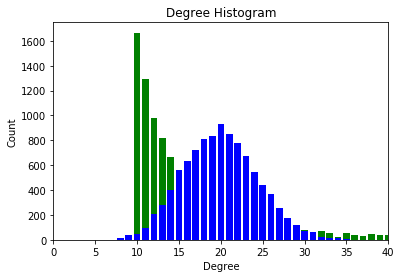

In [18]:
# Another way
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xlim(0, 40)
L = nx.degree_histogram(graph_free_scale_barabasi)
plt.bar(range(len(L)),L, width=0.80, color='g')
L = nx.degree_histogram(graph_random)
plt.bar(range(len(L)),L, width=0.80, color='b')
plt.show()

### Results Comparison

## Network Attack.

### Random attack

Implement a routine program random_attack $(G, m)$ in Python that perform a random attack on $m$ nodes of graph $G$.

Use the previous routine to calculate the size of the largest connected component
connected in random, small world and scale-free graphs of $1000$ nodes and $4000$ branches after attacks of 10%, 30%, 50%, 70% and 90% of the nodes of the graph.

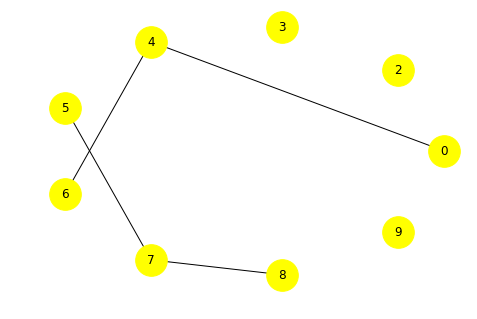

In [125]:
import random
def random_attack(graph, m):
    """
    """
    #print("Removing %s nodes" % (m))
    for remove in range(0,m):
        node = random.choice(list(graph.nodes))
        graph.remove_node(node)

    return graph

def random_attack_percent(graph, percent_nodes_attacked):
    """
    """
    m = graph.order() * percent_nodes_attacked / 100
    return random_attack(graph, round(m))

n = 10
e = 4
random.seed = 0
percent_nodes_attacked = 10
graph = nx.gnm_random_graph(n, e , seed = 0)
graph_attacked = random_attack_percent(graph, percent_nodes_attacked)
nx.draw_circular(graph_attacked, with_labels = True, node_color = "yellow", node_size = 1000)

In [196]:
def node_attack_old(initial_graph, percents_nodes_attacked):
    """
    """
    sizes_max_connected_subgraph = []
    for percent_nodes_attacked in percents_nodes_attacked:
        #print("Attacking %s nodes" % (percent_nodes_attacked))
        graph = initial_graph.copy()
        if percent_nodes_attacked == 0:
            attacked_graph = graph
        else:
            attacked_graph = random_attack_percent(graph, percent_nodes_attacked)
        largest_cc = max(nx.connected_components(attacked_graph), key=len) 
        largest_connected_subgraph = attacked_graph.subgraph(largest_cc)
        sizes_max_connected_subgraph.append(largest_connected_subgraph.size())
    return sizes_max_connected_subgraph

def node_attack(graph, percents_nodes_attacked, attack_method_name='random_attack_percent'):
    """
    Reusing previous graph
    """
    sizes_max_connected_subgraph = []
    percent_prev = 0
    for percent_nodes_attacked in percents_nodes_attacked:
        #print("Attacking %s nodes" % (percent_nodes_attacked))
        percent_current = percent_nodes_attacked - percent_prev
        percent_prev = percent_nodes_attacked
        if percent_current == 0:
            attacked_graph = graph
        else:
            attacked_graph = globals()[attack_method_name](graph, percent_current)
        largest_cc = max(nx.connected_components(attacked_graph), key=len) 
        largest_connected_subgraph = attacked_graph.subgraph(largest_cc)
        sizes_max_connected_subgraph.append(largest_connected_subgraph.size())
        graph = attacked_graph
    return sizes_max_connected_subgraph

def do_attacks(percents_nodes_attacked, nodes, edges,
               attack_method_name='random_attack_percent', seed=0):
    """
    """
    random.seed = seed
    n = nodes
    e = edges

    graph_random = nx.gnm_random_graph(n, e, seed = SEED)
    k = int(e*2/n)
    p = 0.5
    graph_small_world = nx.watts_strogatz_graph(n, k, p, seed = SEED)
    k = int(e/n)
    graph_scale_free = nx.barabasi_albert_graph(n, k, seed = SEED)

    random_size = node_attack(graph_random.copy(), percents_nodes_attacked)
    small_world_size = node_attack(graph_small_world.copy(), percents_nodes_attacked)
    free_scale_size = node_attack(graph_scale_free.copy(), percents_nodes_attacked)

    d = {'Random': random_size, 'Small-World': small_world_size, 'Scale-Free': free_scale_size}
    df = pd.DataFrame(data=d, index = [str(i)+'%' for i in percents_nodes_attacked])
    display(df)
    
    return graph_random, graph_small_world, graph_scale_free

In [204]:
percents_nodes_attacked = [0, 10, 30, 40, 50, 60, 70, 80, 90]
nodes = 1000
edges = 4000
graph_random, graph_small_world, graph_scale_free =\
    do_attacks(percents_nodes_attacked, nodes, edges, 
               attack_method_name='random_attack_percent', seed=0)

,Random,Small-World,Scale-Free
0%,4000,4000,3984
10%,3255,3222,3247
30%,2051,2060,2164
40%,1632,1655,1659
50%,1304,1349,1317
60%,1062,1091,989
70%,866,888,809
80%,720,717,667
90%,593,583,517


In [158]:
d = {'Random': get_graph_metrics(graph_random), 
     'Small-World': get_graph_metrics(graph_small_world),
     'Scale-Free': get_graph_metrics(graph_scale_free)}
df = pd.DataFrame(data=d, index = ['Degree centrality', 'Closeness centrality',
                                  'Betweenness centrality', 'Graph clique number',
                                  'Average clustering', 'Max k-core k',
                                  'Average shortest path length'])
display(df)

,Random,Small-World,Scale-Free
Degree centrality,0.008008,0.008008,0.007976
Closeness centrality,0.282338,0.270169,0.318568
Betweenness centrality,0.002557,0.002711,0.002166
Graph clique number,3.000000,5.000000,4.000000
Average clustering,0.010371,0.091460,0.037346
Max k-core k,5.000000,5.000000,4.000000
Average shortest path length,3.552160,3.705846,3.161854


10 10 1
9
[(0, 1), (1, 4), (2, 3), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
[(1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (3, 2), (4, 1), (4, 3)]
(3, 2)


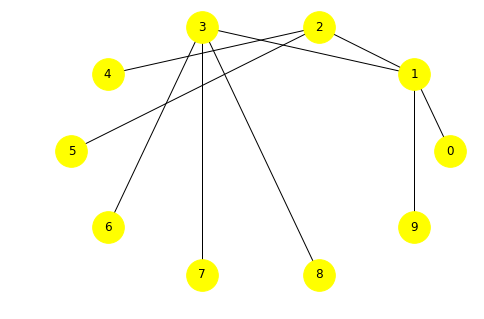

In [180]:
n = 10
e = 10
k = int(e/n)
print (n, e, k)
g = nx.barabasi_albert_graph(n, k)
print(g.size())
print(g.degree())
s = sorted([(b,a) for (a,b) in g.degree()])
print(s)
print(s[-3])
#print(max(g.degree().items(), key = lambda x: x[1]))
nx.draw_circular(g, with_labels = True, node_color = "yellow", node_size = 1000)

### Degree attack

Implement a method *degree_attack(G, m)* in Python that performs an attack based on degrees to $m$ nodes of graph $G$.

Use the previous routine to calculate the size of the largest connected component in random, small world and scale-free graphs of $1000$ nodes and $4000$ branches after attacks of 10%, 30%, 50%, 70% and 90% of the nodes.

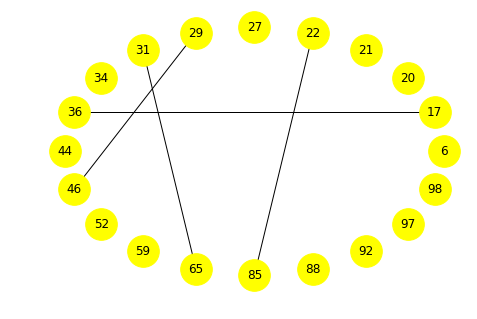

In [192]:
def degree_attack(graph, m):
    """
    """
    degree_dist_sorted = sorted([(b,a) for (a,b) in graph.degree()])
    pos = -1
    for remove in range(0,m):
        (degree, node) = degree_dist_sorted[pos]
        #print("Removing node %s with degree %s" % (node, degree))
        graph.remove_node(node)
        pos -= 1

    return graph

def degree_attack_percent(graph, percent_nodes_attacked):
    """
    """
    m = graph.order() * percent_nodes_attacked / 100
    return degree_attack(graph, round(m))

n = 100
e = 400
random.seed = 0
percent_nodes_attacked = 80
graph = nx.gnm_random_graph(n, e , seed = 0)
graph_attacked = degree_attack_percent(graph, percent_nodes_attacked)
nx.draw_circular(graph_attacked, with_labels = True, node_color = "yellow", node_size = 1000)

In [208]:
percents_nodes_attacked = [0, 10, 30, 40, 50, 60, 70, 80, 90]
nodes = 1000
edges = 4000
graph_random, graph_small_world, graph_scale_free =\
    do_attacks(percents_nodes_attacked, nodes, edges, 
               attack_method_name='degree_attack_percent', seed=0)

,Random,Small-World,Scale-Free
0%,4000,4000,3984
10%,3276,3264,3176
30%,2088,2069,2117
40%,1722,1686,1747
50%,1394,1347,1472
60%,1121,1101,1203
70%,895,890,971
80%,712,733,794
90%,562,598,640


In [ ]:
d = {'Random': get_graph_metrics(graph_random), 
     'Small-World': get_graph_metrics(graph_small_world),
     'Scale-Free': get_graph_metrics(graph_scale_free)}
df = pd.DataFrame(data=d, index = ['Degree centrality', 'Closeness centrality',
                                  'Betweenness centrality', 'Graph clique number',
                                  'Average clustering', 'Max k-core k',
                                  'Average shortest path length'])
display(df)

### Comparisons
Compare the result obtained in the two previous sections.